In [93]:
import os
import numpy as np
import pandas as pd
import tqdm
from sklearn.preprocessing import StandardScaler
from collections import Counter
from scipy import stats
import networkx as nx
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch_geometric.data import Data
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.optim as optim
from scipy.stats import skew, kurtosis


## ROIT Data Loading and Preprocessing

In [94]:
class ROILoader:
    def __init__(self, roits_dir="./fmri_roits/", atlas_name="cc200", expected_rois=200):
        self.roits_dir = roits_dir
        self.atlas_name = atlas_name
        self.expected_rois = expected_rois
        self.scaler = StandardScaler()
        self.loaded_cache = {}

    def load(self, subject_id):
        if subject_id in self.loaded_cache:
            return self.loaded_cache[subject_id]

        filepath = os.path.join(self.roits_dir, f"{subject_id}_rois_{self.atlas_name}.1D")
        if not os.path.exists(filepath):
            raise FileNotFoundError(f"Missing file: {filepath}")
        
        try:
            ts = np.loadtxt(filepath)
        except Exception as e:
            raise ValueError(f"Could not load {filepath}: {e}")

        if ts.shape[1] != self.expected_rois:
            raise ValueError(f"Unexpected shape: {ts.shape}, expected {self.expected_rois} ROIs")

        if np.any(np.isnan(ts)) or np.any(np.isinf(ts)):
            ts = np.nan_to_num(ts)

        self.loaded_cache[subject_id] = ts
        return ts
    
def compute_pearson_connectivity(ts):
    """
    Compute Pearson correlation matrix and apply Fisher z-transformation.
    Args:
        ts (np.ndarray): Time series array of shape [timepoints, regions]
    Returns:
        conn_matrix (np.ndarray): Z-transformed correlation matrix [regions, regions]
    """
    # Standardize time series (across timepoints)
    ts = (ts - ts.mean(axis=0)) / (ts.std(axis=0) + 1e-8)

    # Vectorized Pearson correlation
    corr_matrix = np.corrcoef(ts.T)

    # Clip to avoid arctanh blow-up
    np.clip(corr_matrix, -0.999, 0.999, out=corr_matrix)
    
    # Apply Fisher z-transform
    z_matrix = np.arctanh(corr_matrix)
    
    return z_matrix

# === Feature Extraction Class ===
class ROIFeatureExtractor:
    def __init__(self, pheno_df, n_regions=200):
        self.pheno = pheno_df
        self.n_regions = n_regions

    def compute_pearson_connectivity(self, ts):
        ts = (ts - ts.mean(axis=0)) / (ts.std(axis=0) + 1e-8)
        corr = np.corrcoef(ts.T)
        np.clip(corr, -0.999, 0.999, out=corr)
        return np.arctanh(corr)

    def extract_graph_features(self, conn_matrix):
        G = nx.from_numpy_array(np.abs(conn_matrix))
        features = {
            'clustering': np.array(list(nx.clustering(G).values())),
            'betweenness': np.array(list(nx.betweenness_centrality(G).values())),
            'closeness': np.array(list(nx.closeness_centrality(G).values())),
            'degree': np.array(list(dict(G.degree()).values()))
        }
        return features

    def extract_metadata(self, sub_id):
        row = self.pheno[self.pheno['FILE_ID'] == sub_id]
        if row.empty:
            raise ValueError(f"No phenotype entry for subject {sub_id}")
        dx = row['DX_GROUP'].iloc[0]
        if dx not in [1, 2]:
            raise ValueError(f"Invalid DX_GROUP {dx} for {sub_id}")
        label = 1 if dx == 1 else 0
        meta = {
            'label': label,
            'age': row['AGE_AT_SCAN'].iloc[0],
            'sex': row['SEX'].iloc[0],
            'site': row['SITE_ID'].iloc[0]
        }
        return meta

    def process_subject(self, sub_id, ts):
        metadata = self.extract_metadata(sub_id)
        conn_matrix = self.compute_pearson_connectivity(ts)
        features = self.extract_graph_features(conn_matrix)
        return {
            'connectivity': conn_matrix,
            'features': features,
            **metadata
        }
    
pheno = pd.read_csv('./Phenotypic_V1_0b_preprocessed1.csv').iloc[1:].reset_index(drop=True)
loader = ROILoader()
extractor = ROIFeatureExtractor(pheno_df=pheno)

all_fmri_data = {}
failed_subjects = []

# === Process All fMRI Subjects ===
for sub_id in tqdm.tqdm(pheno['FILE_ID'].dropna().unique(), desc="Processing fMRI"):
    try:
        subject_row = pheno[pheno['FILE_ID'] == sub_id]
        if subject_row.empty or subject_row['DX_GROUP'].iloc[0] not in [1, 2]:
            continue

        ts = loader.load(sub_id)
        result = extractor.process_subject(sub_id, ts)
        features = result['features']
        conn_matrix = result['connectivity']

        # === Flatten feature dictionary into a single vector
        flat_features = np.concatenate([v for v in features.values()])

        all_fmri_data[sub_id] = {
            'features': flat_features,
            'connectivity': conn_matrix,
            'label': result['label'],
            'age': result['age'],
            'site': result['site'],
            'sex': result['sex']
        }

    except Exception as e:
        failed_subjects.append((sub_id, str(e)))
        continue

print(f"\n✅ Loaded {len(all_fmri_data)} fMRI subjects")
print(f"❌ Failed: {len(failed_subjects)}")
if failed_subjects:
    print("\nSample errors:")
    for sid, err in failed_subjects[:3]:
        print(f"  {sid}: {err}")




Processing fMRI:   4%|▍         | 40/1036 [00:45<19:09,  1.15s/it]/Users/joemargolis/Desktop/ASD2/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/joemargolis/Desktop/ASD2/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
Processing fMRI: 100%|██████████| 1036/1036 [19:27<00:00,  1.13s/it]


✅ Loaded 1035 fMRI subjects
❌ Failed: 1

Sample errors:
  no_filename: Missing file: ./fmri_roits/no_filename_rois_cc200.1D


## sMRI Data Loading

In [95]:
import pickle

# Load the engineered sMRI feature dictionary
with open("engineered_smri_features.pkl", "rb") as f:
    engineered_sMRI = pickle.load(f)

print(f"✅ Loaded {len(engineered_sMRI)} engineered sMRI subjects")

with open("engineered_fMRI.pkl", "rb") as f:
    engineered_fMRI = pickle.load(f)

print(f"✅ Loaded {len(engineered_fMRI)} engineered fMRI subjects")

# === sMRI Feature Extractor ===
class SMRIFeatureExtractor:
    def __init__(self, smri_path="./freesurfer/merged_freesurfer.csv", pheno_df=None,
                 fs_id_col="subject", pheno_id_col="FILE_ID"):
        self.smri_df = pd.read_csv(smri_path)
        self.pheno_df = pheno_df
        self.fs_id_col = fs_id_col
        self.pheno_id_col = pheno_id_col

    def get_subject_features(self, subject_id):
        row = self.smri_df[self.smri_df[self.fs_id_col] == subject_id]
        if row.empty:
            raise ValueError(f"No sMRI data for subject {subject_id}")
        return row.drop(columns=[self.fs_id_col]).values.squeeze()

    def get_label_metadata(self, subject_id):
        row = self.pheno_df[self.pheno_df[self.pheno_id_col] == subject_id]
        if row.empty:
            raise ValueError(f"No phenotype data for subject {subject_id}")
        dx = row['DX_GROUP'].iloc[0]
        if dx not in [1, 2]:
            raise ValueError(f"Invalid DX_GROUP {dx}")
        return {
            'label': 1 if dx == 1 else 0,
            'age': row['AGE_AT_SCAN'].iloc[0],
            'sex': row['SEX'].iloc[0],
            'site': row['SITE_ID'].iloc[0]
        }

    def process_subject(self, subject_id):
        features = self.get_subject_features(subject_id)
        meta = self.get_label_metadata(subject_id)
        return {
            'features': features,
            **meta
        }

# === Initialize sMRI Extractor ===
smri_extractor = SMRIFeatureExtractor(
    smri_path="./freesurfer/merged_freesurfer.csv",
    pheno_df=pheno,
    fs_id_col="subject",
    pheno_id_col="FILE_ID"
)

all_smri_data = {}
all_smri_labels = {}
failed_smri_subjects = []

# === Process All Subjects ===
for sub_id in tqdm.tqdm(pheno['FILE_ID'].dropna().unique(), desc="Processing sMRI subjects"):
    try:
        result = smri_extractor.process_subject(sub_id)
        features = result['features']
        label = result['label']

        # === Build synthetic connectivity: full minus identity
        n_regions = len(features)
        conn_matrix = np.ones((n_regions, n_regions)) - np.eye(n_regions)

        all_smri_data[sub_id] = {
            'features': features,
            'connectivity': conn_matrix,
            'label': label,
            'age': result['age'],
            'site': result['site'],
            'sex': result['sex']
        }

        all_smri_labels[sub_id] = label

    except Exception as e:
        failed_smri_subjects.append((sub_id, str(e)))
        continue

print(f"\n✅ Loaded: {len(all_smri_data)} sMRI subjects")
print(f"❌ Failed: {len(failed_smri_subjects)}")
print(f"Label distribution: {Counter(all_smri_labels.values())}")

# === Show some failed subjects ===
if failed_smri_subjects:
    print("\nSample sMRI failures:")
    for sub_id, err in failed_smri_subjects[:5]:
        print(f"{sub_id}: {err}")

✅ Loaded 1035 engineered sMRI subjects
✅ Loaded 1035 engineered fMRI subjects


Processing sMRI subjects: 100%|██████████| 1036/1036 [00:00<00:00, 1228.16it/s]


✅ Loaded: 1035 sMRI subjects
❌ Failed: 1
Label distribution: Counter({0: 530, 1: 505})

Sample sMRI failures:
no_filename: No sMRI data for subject no_filename


## Building Graph Tensors

In [96]:
from torch.utils.data import Dataset

class BrainGraphDataset(Dataset):
    def __init__(self, subject_dict, edge_strategy='full'):
        """
        subject_dict: Dict[sub_id] = {'features': ..., 'connectivity': ..., 'label': ...}
        edge_strategy: 'full' or 'threshold'
        """
        self.subjects = list(subject_dict.keys())
        self.data = subject_dict
        self.edge_strategy = edge_strategy

    def __len__(self):
        return len(self.subjects)

    def __getitem__(self, idx):
        sub_id = self.subjects[idx]
        entry = self.data[sub_id]

        x = torch.tensor(entry['features'], dtype=torch.float32).unsqueeze(-1)
        conn = entry['connectivity']
        label = torch.tensor(entry['label'], dtype=torch.long)

        # Create graph edges from connectivity
        edge_index, edge_attr = self.conn_to_edges(conn)
        graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=label)
        return graph

    def conn_to_edges(self, conn_matrix, threshold=0.0):
        """Convert connectivity matrix to PyG edge_index format"""
        conn = np.array(conn_matrix)
        n = conn.shape[0]
        edges = []
        weights = []

        for i in range(n):
            for j in range(n):
                if i != j and (self.edge_strategy == 'full' or abs(conn[i, j]) > threshold):
                    edges.append([i, j])
                    weights.append(conn[i, j])

        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(weights, dtype=torch.float32)
        return edge_index, edge_attr
    
sample_sub_id = list(all_smri_data.keys())[0]
smri_dataset = BrainGraphDataset(all_smri_data)
fmri_dataset = BrainGraphDataset(all_fmri_data)

smri_graph = smri_dataset[smri_dataset.subjects.index(sample_sub_id)]
fmri_graph = fmri_dataset[fmri_dataset.subjects.index(sample_sub_id)]

print("🔍 sMRI Graph:")
print(f"  x shape       : {smri_graph.x.shape}")
print(f"  edge_index    : {smri_graph.edge_index.shape}")
print(f"  edge_attr     : {smri_graph.edge_attr.shape}")
print(f"  label         : {smri_graph.y.item()}")

print("\n🔍 fMRI Graph:")
print(f"  x shape       : {fmri_graph.x.shape}")
print(f"  edge_index    : {fmri_graph.edge_index.shape}")
print(f"  edge_attr     : {fmri_graph.edge_attr.shape}")
print(f"  label         : {fmri_graph.y.item()}")

🔍 sMRI Graph:
  x shape       : torch.Size([277, 1])
  edge_index    : torch.Size([2, 76452])
  edge_attr     : torch.Size([76452])
  label         : 1

🔍 fMRI Graph:
  x shape       : torch.Size([800, 1])
  edge_index    : torch.Size([2, 39800])
  edge_attr     : torch.Size([39800])
  label         : 1


## MaskGNN Model Building

In [97]:
import torch_geometric
from torch_geometric.nn import GATConv, SAGEConv, global_max_pool, global_add_pool

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv, SAGEConv
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool

class BranchMaskGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, dropout=0.3, mask_rate=0.1):
        super(BranchMaskGNN, self).__init__()
        self.mask_rate = mask_rate
        self.mask_token = nn.Parameter(torch.zeros(input_dim))
        nn.init.normal_(self.mask_token, std=0.1)

        self.gcn1 = GCNConv(input_dim, hidden_dim)
        self.sage = SAGEConv(hidden_dim, hidden_dim)
        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, x, edge_index, batch):
        # Apply input masking
        mask = (torch.rand(x.size(0), device=x.device) < self.mask_rate).float().unsqueeze(1)
        x = x * (1 - mask) + self.mask_token * mask

        x = F.relu(self.gcn1(x, edge_index))
        x = self.dropout_layer(x)

        x = F.relu(self.sage(x, edge_index))
        x = self.dropout_layer(x)

        # Global pooling
        out = global_mean_pool(x, batch)

        return out, mask.squeeze(1)

class DualMaskGNN(nn.Module):
    def __init__(self, 
                 smri_input_dim=46, 
                 fmri_input_dim=6, 
                 hidden_dim=128,
                 num_classes=2,
                 dropout=0.3,
                 node_mask_rate=0.02,
                 edge_mask_rate=0.00,
                 feature_mask_rate=0.02):
        super(DualMaskGNN, self).__init__()

        self.node_mask_rate = node_mask_rate
        self.edge_mask_rate = edge_mask_rate
        self.feature_mask_rate = feature_mask_rate

        self.smri_token = nn.Parameter(torch.randn(smri_input_dim))
        self.fmri_token = nn.Parameter(torch.randn(fmri_input_dim))

        # === sMRI branch ===
        self.smri_conv1 = GATConv(smri_input_dim, hidden_dim)
        self.smri_conv2 = SAGEConv(hidden_dim, hidden_dim)

        # === fMRI branch ===
        self.fmri_conv1 = GATConv(fmri_input_dim, hidden_dim, heads=1, concat=True)
        self.fmri_conv2 = SAGEConv(hidden_dim, hidden_dim)

        # === Fusion gating ===
        self.gate_fc1 = nn.Linear(2 * hidden_dim, hidden_dim)
        self.gate_fc2 = nn.Linear(hidden_dim, 1)
        nn.init.constant_(self.gate_fc2.bias, 1.0)

        # === Classification ===
        self.fusion_head = nn.Linear(hidden_dim, num_classes)

    def apply_mask(self, x, rate, token):
        if rate == 0.0:
            return x
        mask = torch.rand(x.size(0), device=x.device) < rate
        x[mask] = token
        return x

    def forward(self, smri_data, fmri_data):
        x1 = self.apply_mask(smri_data.x, self.node_mask_rate, self.smri_token)
        x2 = self.apply_mask(fmri_data.x, self.node_mask_rate, self.fmri_token)

        # Track which nodes were masked
        smri_mask = (x1 == self.smri_token).all(dim=1).float()
        fmri_mask = (x2 == self.fmri_token).all(dim=1).float()

        # sMRI branch
        h1 = F.relu(self.smri_conv1(x1, smri_data.edge_index))
        h1 = F.dropout(h1, p=0.3, training=self.training)
        h1 = F.relu(self.smri_conv2(h1, smri_data.edge_index))
        smri_out = global_mean_pool(h1, smri_data.batch)

        # fMRI branch
        h2 = F.relu(self.fmri_conv1(x2, fmri_data.edge_index))
        h2 = F.dropout(h2, p=0.3, training=self.training)
        h2 = F.relu(self.fmri_conv2(h2, fmri_data.edge_index))
        fmri_out = global_mean_pool(h2, fmri_data.batch)

        # Gated fusion
        smri_out = F.layer_norm(smri_out, smri_out.shape[1:])
        fmri_out = F.layer_norm(fmri_out, fmri_out.shape[1:])

        # Gated fusion
        smri_norm = F.normalize(smri_out, p=2, dim=1)
        fmri_norm = F.normalize(fmri_out, p=2, dim=1)
        combined = torch.cat([smri_norm, fmri_norm], dim=1)
        h = F.relu(self.gate_fc1(combined))
        h = F.dropout(h, p=0.2, training=self.training)
        gate = torch.sigmoid(self.gate_fc2(h))  # shape [batch_size, 1]

        fused = gate * smri_out + (1 - gate) * fmri_out
        logits = self.fusion_head(fused)

        if not self.training:
            gate_vals = gate.squeeze().detach().cpu().numpy()
            for i, g in enumerate(gate_vals):
                print(f"[Gate] Sample {i:02d} - sMRI: {g:.3f}, fMRI: {1 - g:.3f}")

        return logits, smri_out, fmri_out, smri_mask, fmri_mask, gate




## Modality Matching

In [98]:
from sklearn.decomposition import PCA

from torch.utils.data import Dataset
from torch_geometric.data import Data
import torch
import numpy as np

class DualGraphDataset(Dataset):
    def __init__(self, smri_data, fmri_data, engineered_smri, engineered_fmri, fmri_edge_density=0.5):
        self.smri_data = smri_data
        self.fmri_data = fmri_data
        self.engineered_smri = engineered_smri
        self.engineered_fmri = engineered_fmri
        self.fmri_edge_density = fmri_edge_density  # Top % strongest edges to keep
        self.subjects = list(engineered_smri.keys())  # Assuming keys are aligned

    def __len__(self):
        return len(self.subjects)

    def _make_fully_connected_graph(self, n_nodes):
        row, col = torch.meshgrid(torch.arange(n_nodes), torch.arange(n_nodes), indexing="ij")
        mask = row != col
        edge_index = torch.stack([row[mask], col[mask]], dim=0)
        edge_attr = torch.ones(edge_index.size(1), dtype=torch.float32)
        return edge_index, edge_attr

    def _make_thresholded_edges(self, conn_matrix):
        conn = np.array(conn_matrix)
        n = conn.shape[0]
        np.fill_diagonal(conn, 0)

        flat = np.abs(conn.flatten())
        threshold = np.percentile(flat, (1 - self.fmri_edge_density) * 100)
        mask = np.abs(conn) >= threshold

        # ✅ Prevent empty edge case
        if not np.any(mask):
            print("⚠️ No edges found above threshold — falling back to full graph")
            row, col = np.where(~np.eye(n, dtype=bool))
            edge_index = torch.tensor([row, col], dtype=torch.long)
            edge_attr = torch.ones(edge_index.shape[1], dtype=torch.float32)
            return edge_index, edge_attr

        edge_indices = np.where(mask)
        edge_index = torch.tensor(np.vstack(edge_indices), dtype=torch.long)

        edge_weights = conn[mask]
        # Normalize safely
        edge_weights = (edge_weights - edge_weights.mean()) / (edge_weights.std() + 1e-8)
        edge_attr = torch.tensor(edge_weights, dtype=torch.float32)

        return edge_index, edge_attr

    def _standardize(self, features):
        """Standardize node features column-wise"""
        return (features - features.mean(axis=0)) / (features.std(axis=0) + 1e-8)

    def __getitem__(self, idx):
        sub_id = self.subjects[idx]
        smri_entry = self.smri_data[sub_id]
        fmri_entry = self.fmri_data[sub_id]

        # === sMRI graph ===
        smri_feat = self.engineered_smri[sub_id]  # [nodes, features]
        smri_feat = self._standardize(smri_feat)
        n_nodes_smri = smri_feat.shape[0]

        smri_x = torch.tensor(smri_feat, dtype=torch.float32)
        smri_edge_index, smri_edge_attr = self._make_fully_connected_graph(n_nodes_smri)

        smri_graph = Data(
            x=smri_x,
            edge_index=smri_edge_index,
            edge_attr=smri_edge_attr,
            y=torch.tensor(smri_entry['label'], dtype=torch.long),
            subj=sub_id
        )

        # === fMRI graph ===
        fmri_feat = self.engineered_fmri[sub_id]  # [nodes, features]
        fmri_feat = self._standardize(fmri_feat)
        n_nodes_fmri = fmri_feat.shape[0]

        fmri_x = torch.tensor(fmri_feat, dtype=torch.float32)

        # Threshold edges using connectivity matrix
        fmri_conn = fmri_entry['connectivity']
        fmri_edge_index, fmri_edge_attr = self._make_thresholded_edges(fmri_conn)

        fmri_graph = Data(
            x=fmri_x,
            edge_index=fmri_edge_index,
            edge_attr=fmri_edge_attr,
            y=torch.tensor(fmri_entry['label'], dtype=torch.long),
            subj=sub_id
        )

        return Data(smri=smri_graph, fmri=fmri_graph, y=smri_graph.y)



dual_dataset = DualGraphDataset(
    all_smri_data,
    all_fmri_data,
    engineered_sMRI,
    engineered_fMRI,
    fmri_edge_density=0.15  # keep top 15% edges
)

# Check dataset length and first sample
print(f"✅ Total matched subjects: {len(dual_dataset)}")

# Fetch a sample
sample = dual_dataset[0]
smri_graph = sample.smri
fmri_graph = sample.fmri

# Show quick shape info
print("🔍 Sample 0:")
print(f"  sMRI x shape     : {smri_graph.x.shape}")
print(f"  sMRI edges       : {smri_graph.edge_index.shape}")
print(f"  sMRI label       : {smri_graph.y.item()}")

print(f"  fMRI x shape     : {fmri_graph.x.shape}")
print(f"  fMRI edges       : {fmri_graph.edge_index.shape}")
print(f"  fMRI label       : {fmri_graph.y.item()}")

✅ Total matched subjects: 1035
🔍 Sample 0:
  sMRI x shape     : torch.Size([75, 46])
  sMRI edges       : torch.Size([2, 5550])
  sMRI label       : 1
  fMRI x shape     : torch.Size([200, 12])
  fMRI edges       : torch.Size([2, 6000])
  fMRI label       : 1


In [99]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sample = dual_dataset[0]
sample_smri = sample.smri
sample_fmri = sample.fmri  # <-- Now using real graph objects
sample_smri.batch = torch.zeros(sample_smri.x.size(0), dtype=torch.long)
sample_fmri.batch = torch.zeros(sample_fmri.x.size(0), dtype=torch.long)

model = DualMaskGNN(
    smri_input_dim=46,
    fmri_input_dim=12,
    hidden_dim=64,        # or 128, depending on preference
    num_classes=2,
    dropout=0.3
).to(device)
out = model(sample_smri, sample_fmri)

for i, part in enumerate(out):
    print(f"Part {i} shape: {getattr(part, 'shape', type(part))}")

Part 0 shape: torch.Size([1, 2])
Part 1 shape: torch.Size([1, 64])
Part 2 shape: torch.Size([1, 64])
Part 3 shape: torch.Size([75])
Part 4 shape: torch.Size([200])
Part 5 shape: torch.Size([1, 1])


## Preparing data for training

In [100]:
batch_size = 1  # For GNNs, especially with variable-sized graphs

# === Split Dataset
total_size = len(dual_dataset)
val_size = int(0.2 * total_size)
test_size = int(0.1 * total_size)
train_size = total_size - val_size - test_size

train_set, val_set, test_set = random_split(dual_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

# === DataLoaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

print("✅ DataLoaders ready!")
print(f"  Train size: {len(train_set)}")
print(f"  Val size  : {len(val_set)}")
print(f"  Test size : {len(test_set)}")

✅ DataLoaders ready!
  Train size: 725
  Val size  : 207
  Test size : 103


## Training pipeline

In [101]:
from sklearn.metrics import recall_score


class DualFusionTrainer:
    def __init__(self, model, device='cuda'):
        self.model = model.to(device)
        self.device = device
        self.criterion = torch.nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    def train_epoch(self, loader):
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        for smri_batch, fmri_batch in loader:
            smri_batch = smri_batch.to(self.device)
            fmri_batch = fmri_batch.to(self.device)
            self.optimizer.zero_grad()

            out = self.model(smri_batch, fmri_batch)
            loss = self.criterion(out, smri_batch.y)
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += pred.eq(smri_batch.y).sum().item()
            total += smri_batch.y.size(0)

        return total_loss / len(loader), correct / total

    def evaluate(self, loader):
        self.model.eval()
        all_preds = []
        all_probs = []
        all_labels = []
        total_loss = 0

        with torch.no_grad():
            for smri_batch, fmri_batch in loader:
                smri_batch = smri_batch.to(self.device)
                fmri_batch = fmri_batch.to(self.device)

                out = self.model(smri_batch, fmri_batch)
                loss = self.criterion(out, smri_batch.y)
                total_loss += loss.item()

                probs = F.softmax(out, dim=1)[:, 1].cpu().numpy()
                preds = out.argmax(dim=1).cpu().numpy()
                labels = smri_batch.y.cpu().numpy()

                all_probs.extend(probs)
                all_preds.extend(preds)
                all_labels.extend(labels)

        acc = accuracy_score(all_labels, all_preds)
        auc = roc_auc_score(all_labels, all_probs)
        f1 = f1_score(all_labels, all_preds)
        sens = recall_score(all_labels, all_preds)
        spec = recall_score(all_labels, all_preds, pos_label=0)

        return {
            'loss': total_loss / len(loader),
            'accuracy': acc,
            'auc': auc,
            'f1': f1,
            'sensitivity': sens,
            'specificity': spec
        }

## Cross Validation

In [102]:
from concurrent.futures import ProcessPoolExecutor
import multiprocessing
from sklearn.model_selection import StratifiedKFold
from torch_geometric.data import Batch
import time
from datetime import datetime

def dual_collate_fn(batch):
    smri_list = [sample.smri for sample in batch]
    fmri_list = [sample.fmri for sample in batch]
    labels = [sample.y for sample in batch]

    smri_batch = Batch.from_data_list(smri_list)
    fmri_batch = Batch.from_data_list(fmri_list)

    smri_batch.y = torch.tensor(labels, dtype=torch.long)
    fmri_batch.y = torch.tensor(labels, dtype=torch.long)

    return smri_batch, fmri_batch


def clean_dataset(dataset):
    print(f"✩ Cleaning {len(dataset)} samples...")
    cleaned = []

    for i, data in enumerate(dataset):
        try:
            smri_x = torch.nan_to_num(data.smri.x, nan=0.0, posinf=1.0, neginf=-1.0).clamp(-10, 10)
            fmri_x = torch.nan_to_num(data.fmri.x, nan=0.0, posinf=1.0, neginf=-1.0).clamp(-10, 10)

            smri_edge_attr = data.smri.edge_attr
            if smri_edge_attr is not None:
                smri_edge_attr = torch.nan_to_num(smri_edge_attr, nan=1.0).clamp(-5, 5)

            fmri_edge_attr = data.fmri.edge_attr
            if fmri_edge_attr is not None:
                fmri_edge_attr = torch.nan_to_num(fmri_edge_attr, nan=0.0).clamp(-5, 5)

            new_data = data.clone()
            new_data.smri = data.smri.clone()
            new_data.fmri = data.fmri.clone()
            new_data.smri.x = smri_x
            new_data.fmri.x = fmri_x
            if smri_edge_attr is not None:
                new_data.smri.edge_attr = smri_edge_attr
            if fmri_edge_attr is not None:
                new_data.fmri.edge_attr = fmri_edge_attr

            cleaned.append(new_data)

        except Exception as e:
            print(f"Error cleaning sample {i}: {e}")
            continue

    print(f"✅ Cleaned dataset: {len(cleaned)}/{len(dataset)} samples")
    return cleaned


def safe_metrics_fixed(all_true, all_preds, all_probs):
    try:
        all_probs = np.array(all_probs)
        if all_probs.ndim == 2:
            all_probs = all_probs[:, 1]

        all_probs = np.nan_to_num(all_probs, nan=0.5, posinf=0.9, neginf=0.1)

        acc = accuracy_score(all_true, all_preds)
        f1 = f1_score(all_true, all_preds, zero_division=0)

        if len(np.unique(all_true)) >= 2:
            try:
                auc = roc_auc_score(all_true, all_probs)
            except:
                auc = 0.5
        else:
            auc = 0.5

        try:
            tn, fp, fn, tp = confusion_matrix(all_true, all_preds).ravel()
            sens = tp / (tp + fn + 1e-6)
            spec = tn / (tn + fp + 1e-6)
        except:
            sens = 0.5
            spec = 0.5

        return {'auc': auc, 'accuracy': acc, 'f1': f1, 'sensitivity': sens, 'specificity': spec}

    except Exception as e:
        print(f"Error in metrics: {e}")
        return {'auc': 0.5, 'accuracy': 0.0, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 0.0}


def train_dual_fold_optimized(fold_data):
    fold, train_dataset, val_dataset, device = fold_data
    print(f"\n✨ Fold {fold+1} started on device: {device}")

    train_dataset = clean_dataset(train_dataset)
    val_dataset = clean_dataset(val_dataset)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=dual_collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=dual_collate_fn)

    model = DualMaskGNN(
        smri_input_dim=46,
        fmri_input_dim=12,
        hidden_dim=64,        # or 128, depending on preference
        num_classes=2,
        dropout=0.3
    ).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.7)

    best_auc, patience_counter, max_patience = 0, 0, 5

    for epoch in range(1, 26):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for smri, fmri in train_loader:
            smri, fmri = smri.to(device), fmri.to(device)
            labels = smri.y.to(device)

            optimizer.zero_grad()
            fused_logits, smri_logits, fmri_logits, smri_mask, fmri_mask, gate = model(smri, fmri)
            loss = criterion(fused_logits, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()

            total_loss += loss.item()
            pred = fused_logits.argmax(dim=1)
            correct += pred.eq(labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        avg_loss = total_loss / len(train_loader)

        if epoch % 5 == 0 or epoch <= 3:
            model.eval()
            all_preds, all_probs, all_true = [], [], []

            with torch.no_grad():
                for smri, fmri in val_loader:
                    smri, fmri = smri.to(device), fmri.to(device)
                    labels = smri.y.to(device)
                    fused_logits, smri_logits, fmri_logits, smri_mask, fmri_mask, gate = model(smri, fmri)
                    probs = F.softmax(fused_logits, dim=1)
                    preds = probs.argmax(dim=1)
                    all_preds.extend(preds.cpu().numpy())
                    all_probs.extend(probs.cpu().numpy())
                    all_true.extend(labels.cpu().numpy())

            metrics = safe_metrics_fixed(all_true, all_preds, all_probs)
            auc = metrics['auc']
            scheduler.step(auc)

            print(f"Epoch {epoch} | Loss={avg_loss:.4f} | Train Acc={train_acc:.4f} | Val AUC={auc:.4f}")

            if auc > best_auc:
                best_auc = auc
                best_metrics = metrics
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= max_patience:
                    print("Early stopping triggered")
                    break

    best_metrics['fold'] = fold + 1
    return best_metrics


def run_optimized_cv(dual_dataset, n_splits=5):
    print(f"✨ Starting {n_splits}-fold CV with {len(dual_dataset)} subjects")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    labels = np.array([data.y.item() for data in dual_dataset])

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
        train_set = [dual_dataset[i] for i in train_idx]
        val_set = [dual_dataset[i] for i in val_idx]
        print(f"\nFold {fold+1}: {len(train_set)} train, {len(val_set)} val")
        result = train_dual_fold_optimized((fold, train_set, val_set, device))
        results.append(result)

    return results


def plot_cv_results_fixed(cv_results):
    import matplotlib.pyplot as plt
    if not cv_results:
        print("No results to plot.")
        return

    metrics = ['auc', 'accuracy', 'f1', 'sensitivity', 'specificity']
    folds = [res['fold'] for res in cv_results]

    plt.figure(figsize=(15, 10))
    for i, metric in enumerate(metrics, 1):
        values = [res[metric] for res in cv_results]
        plt.subplot(2, 3, i)
        plt.plot(folds, values, marker='o')
        plt.title(f"{metric.upper()} per Fold")
        plt.xlabel("Fold")
        plt.ylabel(metric.title())
        for f, v in zip(folds, values):
            plt.annotate(f"{v:.2f}", (f, v), textcoords="offset points", xytext=(0,10), ha='center')

    plt.tight_layout()
    plt.show()

    print("\nCV Summary:")
    for m in metrics:
        vals = [res[m] for res in cv_results]
        print(f"{m.upper()}: {np.mean(vals):.4f} ± {np.std(vals):.4f}")



✨ Starting 5-fold CV with 1035 subjects
⚠️ No edges found above threshold — falling back to full graph
⚠️ No edges found above threshold — falling back to full graph
⚠️ No edges found above threshold — falling back to full graph
⚠️ No edges found above threshold — falling back to full graph
⚠️ No edges found above threshold — falling back to full graph
⚠️ No edges found above threshold — falling back to full graph
⚠️ No edges found above threshold — falling back to full graph
⚠️ No edges found above threshold — falling back to full graph
⚠️ No edges found above threshold — falling back to full graph
⚠️ No edges found above threshold — falling back to full graph
⚠️ No edges found above threshold — falling back to full graph
⚠️ No edges found above threshold — falling back to full graph
⚠️ No edges found above threshold — falling back to full graph
⚠️ No edges found above threshold — falling back to full graph
⚠️ No edges found above threshold — falling back to full graph
⚠️ No edges fou

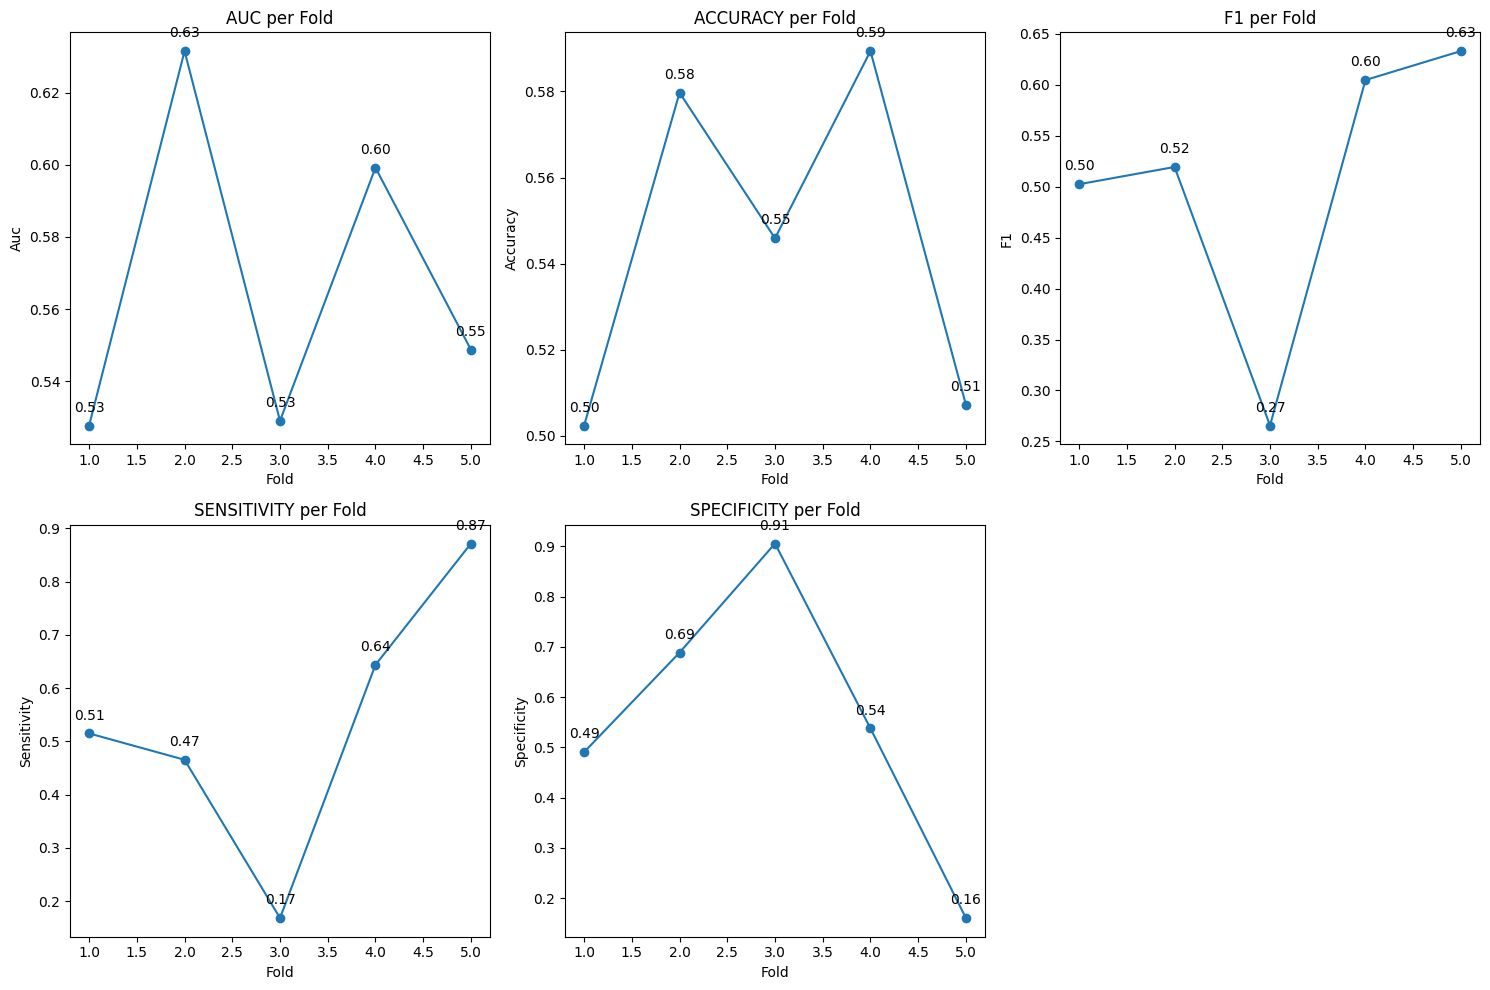


CV Summary:
AUC: 0.5673 ± 0.0413
ACCURACY: 0.5449 ± 0.0358
F1: 0.5050 ± 0.1295
SENSITIVITY: 0.5327 ± 0.2300
SPECIFICITY: 0.5566 ± 0.2454
Fixed implementation ready!


In [103]:
from torch.utils.data import Subset

if __name__ == "__main__":
    # Load your dataset (assuming you have it)
    dual_dataset = DualGraphDataset(
    all_smri_data,
    all_fmri_data,
    engineered_sMRI,
    engineered_fMRI,
    fmri_edge_density=0.15  # keep top 15% edges
)

    # For testing with a small subset
    #small_dataset = [dual_dataset[i] for i in range(500)]
    
    # Run cross-validation
    cv_results = run_optimized_cv(dual_dataset, n_splits=5)
    
    # Plot results
    plot_cv_results_fixed(cv_results)
    
    print("Fixed implementation ready!")

## Analyze cv results

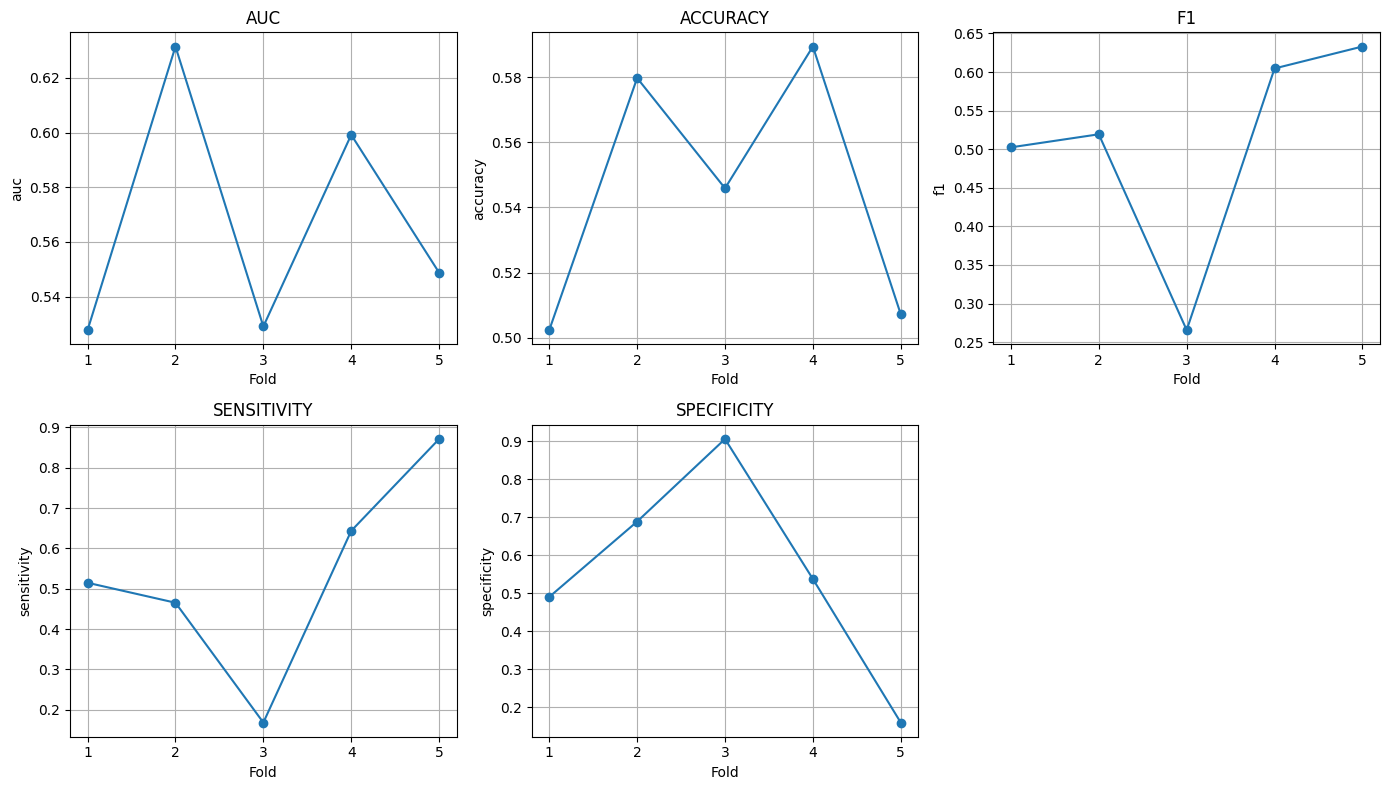

In [104]:
import matplotlib.pyplot as plt

def plot_cv_results(cv_results):
    if not cv_results:
        print("No CV results to plot.")
        return

    metrics = ['auc', 'accuracy', 'f1', 'sensitivity', 'specificity']
    folds = [res['fold'] for res in cv_results]

    plt.figure(figsize=(14, 8))
    for i, metric in enumerate(metrics, 1):
        values = [res[metric] for res in cv_results]
        plt.subplot(2, 3, i)
        plt.plot(folds, values, marker='o', linestyle='-')
        plt.title(metric.upper())
        plt.xlabel('Fold')
        plt.ylabel(metric)
        plt.grid(True)
        plt.xticks(folds)

    plt.tight_layout()
    plt.show()

plot_cv_results(cv_results)

## Get best CV model

In [105]:
from sklearn.model_selection import train_test_split


def get_best_cv_model(cv_results, dataset):
    """Train a model using the best hyperparameters from CV"""
    print("🏆 Training final model using best CV configuration...")
    
    # Find best fold
    best_fold_idx = np.argmax([result['auc'] for result in cv_results])
    best_fold_result = cv_results[best_fold_idx]
    
    print(f"Best fold: {best_fold_result['fold']} (AUC: {best_fold_result['auc']:.4f})")
    
    # Clean dataset
    dataset = clean_dataset(dataset)
    
    # Split into train/test (larger test set for final evaluation)
    labels = [data.y.item() for data in dataset]
    indices = list(range(len(dataset)))
    
    train_idx, test_idx = train_test_split(
        indices, test_size=0.3, random_state=42, stratify=labels
    )
    
    train_dataset = [dataset[i] for i in train_idx]
    test_dataset = [dataset[i] for i in test_idx]
    
    print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")
    
    train_labels = [dataset[i].y.item() for i in train_idx]
    test_labels = [dataset[i].y.item() for i in test_idx]
    print(f"Train label dist: {np.bincount(train_labels)}")
    print(f"Test label dist: {np.bincount(test_labels)}")
    
    return train_dataset, test_dataset, best_fold_result

# Get the best model configuration from your CV results
train_dataset, test_dataset, best_config = get_best_cv_model(cv_results, dual_dataset)

print("✅ Ready to extract best model from CV results")
print("Usage: train_dataset, test_dataset, best_config = get_best_cv_model(cv_results, your_dataset)")

🏆 Training final model using best CV configuration...
Best fold: 2 (AUC: 0.6315)
✩ Cleaning 1035 samples...
⚠️ No edges found above threshold — falling back to full graph
⚠️ No edges found above threshold — falling back to full graph
⚠️ No edges found above threshold — falling back to full graph
⚠️ No edges found above threshold — falling back to full graph
⚠️ No edges found above threshold — falling back to full graph
⚠️ No edges found above threshold — falling back to full graph
⚠️ No edges found above threshold — falling back to full graph
⚠️ No edges found above threshold — falling back to full graph
⚠️ No edges found above threshold — falling back to full graph
⚠️ No edges found above threshold — falling back to full graph
⚠️ No edges found above threshold — falling back to full graph
⚠️ No edges found above threshold — falling back to full graph
⚠️ No edges found above threshold — falling back to full graph
⚠️ No edges found above threshold — falling back to full graph
⚠️ No edge

## TRain final model

In [106]:
def extract_mask_importance(model, data_loader, device):
    model.eval()
    smri_masks = []
    fmri_masks = []

    with torch.no_grad():
        for smri_batch, fmri_batch in data_loader:
            smri_batch = smri_batch.to(device)
            fmri_batch = fmri_batch.to(device)

            _, _, _, smri_mask, fmri_mask, _ = model(smri_batch, fmri_batch)

            if smri_mask is not None and fmri_mask is not None:
                smri_masks.append(smri_mask.cpu())
                fmri_masks.append(fmri_mask.cpu())

    # Concatenate all node-wise masks
    smri_mask_all = torch.cat(smri_masks, dim=0)  # shape: [total_nodes]
    fmri_mask_all = torch.cat(fmri_masks, dim=0)

    # Group by region index (assumes same ordering)
    num_smri_nodes = smri_batch.x.shape[0] // smri_batch.num_graphs
    num_fmri_nodes = fmri_batch.x.shape[0] // fmri_batch.num_graphs

    smri_mask_mean = smri_mask_all.view(-1, num_smri_nodes).mean(dim=0).numpy()
    fmri_mask_mean = fmri_mask_all.view(-1, num_fmri_nodes).mean(dim=0).numpy()

    return smri_mask_mean, fmri_mask_mean



def evaluate_model(model, data_loader, device):
    model.eval()
    all_probs = []
    all_true = []

    with torch.no_grad():
        for smri_batch, fmri_batch in data_loader:
            smri_batch = smri_batch.to(device)
            fmri_batch = fmri_batch.to(device)

            fused_logits, _, _, _, _ = model(smri_batch, fmri_batch)
            probs = torch.softmax(fused_logits, dim=1)[:, 1]
            labels = smri_batch.y

            all_probs.extend(probs.cpu().numpy())
            all_true.extend(labels.cpu().numpy())

    auc = roc_auc_score(all_true, all_probs)
    acc = accuracy_score(all_true, [int(p >= 0.5) for p in all_probs])
    
    return {"auc": auc, "accuracy": acc}

def train_final_model(train_dataset, val_dataset, device=None):
    """Train final model with dynamic weighting and return history."""

    if device is None:
        device = (
            "mps" if torch.backends.mps.is_available() else 
            "cuda" if torch.cuda.is_available() else 
            "cpu"
        )
    print(f"🧹 Cleaning final datasets... (Using device: {device})")

    train_dataset = clean_dataset(train_dataset)
    val_dataset = clean_dataset(val_dataset)

    train_loader = DataLoader(
        train_dataset, batch_size=16, shuffle=True,
        collate_fn=dual_collate_fn, num_workers=0, pin_memory=False, drop_last=True
    )
    val_loader = DataLoader(
        val_dataset, batch_size=32, shuffle=False,
        collate_fn=dual_collate_fn, num_workers=0, pin_memory=False
    )

    model = DualMaskGNN(
        smri_input_dim=46,
        fmri_input_dim=12,
        hidden_dim=64,        # or 128, depending on preference
        num_classes=2,
        dropout=0.3
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.7)

    best_val_auc, best_model_state = 0, None
    patience_counter = 0
    max_patience = 5
    max_epochs = 25

    losses_per_epoch = []
    accuracies_per_epoch = []
    val_aucs_per_epoch = []

    for epoch in range(1, max_epochs + 1):
        model.train()

        smri_weight = 0.3 + 0.3 * (epoch / max_epochs)
        fmri_weight = 0.4 - 0.2 * (epoch / max_epochs)

        total_loss, total_correct, total_samples = 0, 0, 0

        for smri, fmri in train_loader:
            smri, fmri = smri.to(device), fmri.to(device)
            labels = smri.y.to(device)

            optimizer.zero_grad()
            fused_logits, smri_logits, fmri_logits, smri_mask, fmri_mask, gate = model(smri, fmri)
            loss = criterion(fused_logits, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()

            total_loss += loss.item()
            total_correct += fused_logits.argmax(dim=1).eq(labels).sum().item()
            total_samples += labels.size(0)

        train_acc = total_correct / total_samples
        avg_loss = total_loss / len(train_loader)
        losses_per_epoch.append(avg_loss)
        accuracies_per_epoch.append(train_acc)

        model.eval()
        all_preds, all_probs, all_true = [], [], []

        with torch.no_grad():
            for smri, fmri in val_loader:
                smri, fmri = smri.to(device), fmri.to(device)
                labels = smri.y.to(device)

                fused_logits, smri_logits, fmri_logits, smri_mask, fmri_mask, gate = model(smri, fmri)
                probs = F.softmax(fused_logits, dim=1)
                preds = torch.argmax(probs, dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
                all_true.extend(labels.cpu().numpy())

        metrics = safe_metrics_fixed(all_true, all_preds, all_probs)
        auc = metrics['auc']
        val_aucs_per_epoch.append(auc)
        scheduler.step(auc)

        print(f"✅ [FINAL MODEL | EPOCH {epoch}] Loss={avg_loss:.4f}, Train Acc={train_acc:.4f}, Val AUC={auc:.4f}")

        if auc > best_val_auc:
            best_val_auc = auc
            best_model_state = model.state_dict()
            patience_counter = 0
            print(f"   🎉 New best AUC: {auc:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= max_patience:
                print(f"⏹️ Early stopping at epoch {epoch}")
                break

    model.load_state_dict(best_model_state)
    smri_mask_importance, fmri_mask_importance = extract_mask_importance(model, val_loader, device)

    return {
        "model": model,
        "best_metrics": {"val_auc": best_val_auc},
        "training_history": {
            "losses": losses_per_epoch,
            "accuracies": accuracies_per_epoch,
            "test_aucs": val_aucs_per_epoch,
        },
        "device": device,
        "test_loader": val_loader,
        "smri_mask_importance": smri_mask_importance,
        "fmri_mask_importance": fmri_mask_importance,
    }


🏆 Training final model using best CV configuration...
Best fold: 2 (AUC: 0.6315)
✩ Cleaning 1035 samples...
⚠️ No edges found above threshold — falling back to full graph
⚠️ No edges found above threshold — falling back to full graph
⚠️ No edges found above threshold — falling back to full graph
⚠️ No edges found above threshold — falling back to full graph
⚠️ No edges found above threshold — falling back to full graph
⚠️ No edges found above threshold — falling back to full graph
⚠️ No edges found above threshold — falling back to full graph
⚠️ No edges found above threshold — falling back to full graph
⚠️ No edges found above threshold — falling back to full graph
⚠️ No edges found above threshold — falling back to full graph
⚠️ No edges found above threshold — falling back to full graph
⚠️ No edges found above threshold — falling back to full graph
⚠️ No edges found above threshold — falling back to full graph
⚠️ No edges found above threshold — falling back to full graph
⚠️ No edge

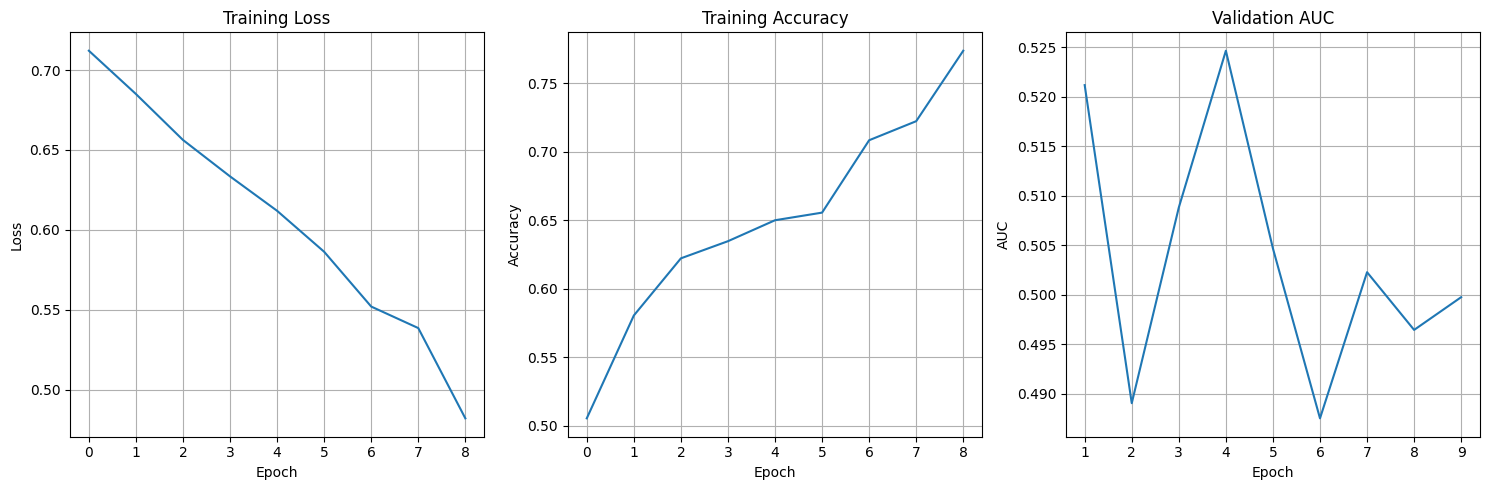

✅ Final model training completed!


In [107]:
# First, get best model from CV
train_dataset, test_dataset, best_config = get_best_cv_model(cv_results, dual_dataset)

# Train the final model (device auto-detected inside)
training_results = train_final_model(train_dataset, test_dataset)

# Display results
print(f"\n📊 Final Model Training Results:")
print(f"Best CV fold performance: AUC={best_config['auc']:.4f}")
print(f"Final model performance: {training_results['best_metrics']}")

# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

history = training_results['training_history']

# Training loss
axes[0].plot(history['losses'])
axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)

# Training accuracy
axes[1].plot(history['accuracies'])
axes[1].set_title('Training Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].grid(True)

# Validation AUC (every epoch)
axes[2].plot(range(1, len(history['test_aucs']) + 1), history['test_aucs'])
axes[2].set_title('Validation AUC')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('AUC')
axes[2].grid(True)

plt.tight_layout()
plt.show()

print("✅ Final model training completed!")

[Gate] Sample 00 - sMRI: 0.797, fMRI: 0.203
[Gate] Sample 01 - sMRI: 0.803, fMRI: 0.197
[Gate] Sample 02 - sMRI: 0.789, fMRI: 0.211
[Gate] Sample 03 - sMRI: 0.782, fMRI: 0.218
[Gate] Sample 04 - sMRI: 0.769, fMRI: 0.231
[Gate] Sample 05 - sMRI: 0.788, fMRI: 0.212
[Gate] Sample 06 - sMRI: 0.779, fMRI: 0.221
[Gate] Sample 07 - sMRI: 0.788, fMRI: 0.212
[Gate] Sample 08 - sMRI: 0.788, fMRI: 0.212
[Gate] Sample 09 - sMRI: 0.786, fMRI: 0.214
[Gate] Sample 10 - sMRI: 0.776, fMRI: 0.224
[Gate] Sample 11 - sMRI: 0.801, fMRI: 0.199
[Gate] Sample 12 - sMRI: 0.786, fMRI: 0.214
[Gate] Sample 13 - sMRI: 0.776, fMRI: 0.224
[Gate] Sample 14 - sMRI: 0.809, fMRI: 0.191
[Gate] Sample 15 - sMRI: 0.776, fMRI: 0.224
[Gate] Sample 16 - sMRI: 0.782, fMRI: 0.218
[Gate] Sample 17 - sMRI: 0.777, fMRI: 0.223
[Gate] Sample 18 - sMRI: 0.785, fMRI: 0.215
[Gate] Sample 19 - sMRI: 0.805, fMRI: 0.195
[Gate] Sample 20 - sMRI: 0.779, fMRI: 0.221
[Gate] Sample 21 - sMRI: 0.797, fMRI: 0.203
[Gate] Sample 22 - sMRI: 0.792, 

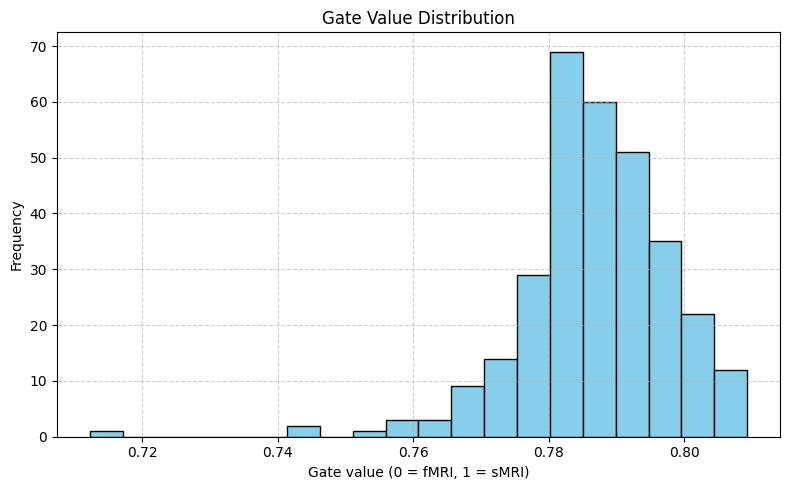

In [108]:
import matplotlib.pyplot as plt

def plot_gate_distribution(model, data_loader, device):
    model.eval()
    all_gates = []

    with torch.no_grad():
        for smri_batch, fmri_batch in data_loader:
            smri_batch = smri_batch.to(device)
            fmri_batch = fmri_batch.to(device)

            # Forward pass to get gate values
            _, _, _, _, _, gate = model(smri_batch, fmri_batch)
            all_gates.extend(gate.squeeze().cpu().numpy())

    # Plot histogram
    plt.figure(figsize=(8, 5))
    plt.hist(all_gates, bins=20, color='skyblue', edgecolor='black')
    plt.title("Gate Value Distribution")
    plt.xlabel("Gate value (0 = fMRI, 1 = sMRI)")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

final_model = training_results['model']
device = training_results['device']
test_loader = training_results['test_loader']

plot_gate_distribution(final_model, test_loader, device)



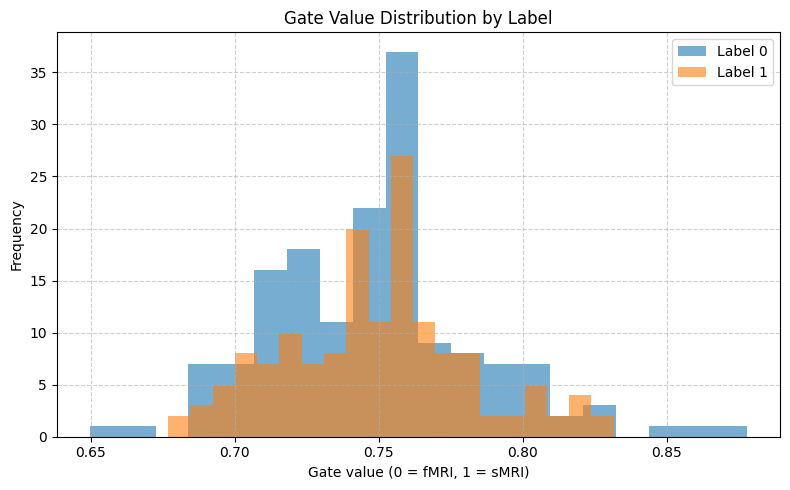

In [109]:
def plot_gate_distribution_by_label(model, data_loader, device):
    model.eval()
    gate_values = {0: [], 1: []}  # Assuming binary labels: 0 and 1

    with torch.no_grad():
        for smri_batch, fmri_batch in data_loader:
            smri_batch = smri_batch.to(device)
            fmri_batch = fmri_batch.to(device)
            labels = smri_batch.y.cpu().numpy()

            # === sMRI branch
            x1 = smri_batch.x
            x1 = F.relu(model.smri_conv1(x1, smri_batch.edge_index))
            x1 = F.dropout(x1, p=0.3, training=False)
            x1 = F.relu(model.smri_conv2(x1, smri_batch.edge_index))
            smri_out = global_mean_pool(x1, smri_batch.batch)

            # === fMRI branch
            x2 = fmri_batch.x
            x2 = F.relu(model.fmri_conv1(x2, fmri_batch.edge_index))
            x2 = F.dropout(x2, p=0.3, training=False)
            x2 = F.relu(model.fmri_conv2(x2, fmri_batch.edge_index))
            fmri_out = global_mean_pool(x2, fmri_batch.batch)

            # === Gate values
            combined = torch.cat([smri_out, fmri_out], dim=1)
            h = F.relu(model.gate_fc1(combined))
            h = F.dropout(h, p=0.2, training=False)
            gate = torch.sigmoid(model.gate_fc2(h)).squeeze().cpu().numpy()

            # Log per-label
            for g, label in zip(gate, labels):
                gate_values[label].append(g)

    # === Plotting
    plt.figure(figsize=(8, 5))
    for label, values in gate_values.items():
        plt.hist(values, bins=20, alpha=0.6, label=f"Label {label}")
    plt.xlabel("Gate value (0 = fMRI, 1 = sMRI)")
    plt.ylabel("Frequency")
    plt.title("Gate Value Distribution by Label")
    plt.legend()
    plt.tight_layout()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()



final_model = training_results['model']
device = training_results['device']
test_loader = training_results['test_loader']

plot_gate_distribution_by_label(final_model, test_loader, device)

[Gate] Sample 00 - sMRI: 0.797, fMRI: 0.203
[Gate] Sample 01 - sMRI: 0.803, fMRI: 0.197
[Gate] Sample 02 - sMRI: 0.789, fMRI: 0.211
[Gate] Sample 03 - sMRI: 0.782, fMRI: 0.218
[Gate] Sample 04 - sMRI: 0.769, fMRI: 0.231
[Gate] Sample 05 - sMRI: 0.788, fMRI: 0.212
[Gate] Sample 06 - sMRI: 0.780, fMRI: 0.220
[Gate] Sample 07 - sMRI: 0.784, fMRI: 0.216
[Gate] Sample 08 - sMRI: 0.788, fMRI: 0.212
[Gate] Sample 09 - sMRI: 0.786, fMRI: 0.214
[Gate] Sample 10 - sMRI: 0.776, fMRI: 0.224
[Gate] Sample 11 - sMRI: 0.801, fMRI: 0.199
[Gate] Sample 12 - sMRI: 0.789, fMRI: 0.211
[Gate] Sample 13 - sMRI: 0.775, fMRI: 0.225
[Gate] Sample 14 - sMRI: 0.811, fMRI: 0.189
[Gate] Sample 15 - sMRI: 0.776, fMRI: 0.224
[Gate] Sample 16 - sMRI: 0.781, fMRI: 0.219
[Gate] Sample 17 - sMRI: 0.777, fMRI: 0.223
[Gate] Sample 18 - sMRI: 0.785, fMRI: 0.215
[Gate] Sample 19 - sMRI: 0.805, fMRI: 0.195
[Gate] Sample 20 - sMRI: 0.781, fMRI: 0.219
[Gate] Sample 21 - sMRI: 0.796, fMRI: 0.204
[Gate] Sample 22 - sMRI: 0.791, 

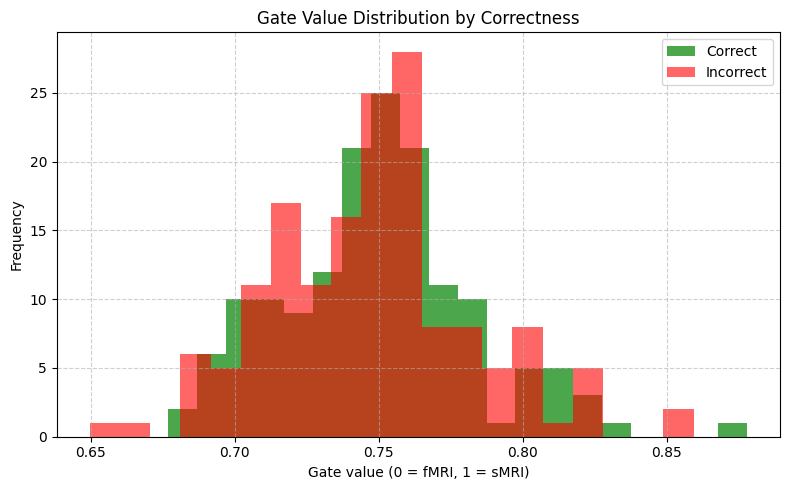

In [110]:
from sklearn.metrics import roc_curve

# Get predictions
final_model.eval()
all_probs, all_true = [], []
with torch.no_grad():
    for smri, fmri in test_loader:
        smri, fmri = smri.to(device), fmri.to(device)
        fused_logits, *_ = final_model(smri, fmri)
        probs = torch.softmax(fused_logits, dim=1)[:, 1].cpu().numpy()
        labels = smri.y.cpu().numpy()

        all_probs.extend(probs)
        all_true.extend(labels)

# ROC curve and threshold selection (Youden's J statistic)
fpr, tpr, thresholds = roc_curve(all_true, all_probs)
j_scores = tpr - fpr
optimal_threshold = thresholds[j_scores.argmax()]

print(f"🔹 Optimal threshold: {optimal_threshold:.4f}")


def plot_gate_distribution_correctness(model, data_loader, device, threshold=0.5):
    model.eval()
    gate_correct = []
    gate_incorrect = []

    with torch.no_grad():
        for smri_batch, fmri_batch in data_loader:
            smri_batch = smri_batch.to(device)
            fmri_batch = fmri_batch.to(device)
            labels = smri_batch.y.cpu().numpy()

            # === sMRI branch
            x1 = smri_batch.x
            x1 = F.relu(model.smri_conv1(x1, smri_batch.edge_index))
            x1 = F.dropout(x1, p=0.3, training=False)
            x1 = F.relu(model.smri_conv2(x1, smri_batch.edge_index))
            smri_out = global_mean_pool(x1, smri_batch.batch)

            # === fMRI branch
            x2 = fmri_batch.x
            x2 = F.relu(model.fmri_conv1(x2, fmri_batch.edge_index))
            x2 = F.dropout(x2, p=0.3, training=False)
            x2 = F.relu(model.fmri_conv2(x2, fmri_batch.edge_index))
            fmri_out = global_mean_pool(x2, fmri_batch.batch)

            # === Gate and fused prediction
            combined = torch.cat([smri_out, fmri_out], dim=1)
            h = F.relu(model.gate_fc1(combined))
            h = F.dropout(h, p=0.2, training=False)
            gate = torch.sigmoid(model.gate_fc2(h)).squeeze().cpu().numpy()

            gate_tensor = torch.tensor(gate, device=smri_out.device).unsqueeze(1)  # shape [batch_size, 1]
            fused = gate_tensor * smri_out + (1 - gate_tensor) * fmri_out
            logits = model.fusion_head(fused.to(device))
            probs = F.softmax(logits, dim=1).cpu().numpy()
            preds = (probs[:, 1] >= threshold).astype(int)

            for g, pred, true in zip(gate, preds, labels):
                if pred == true:
                    gate_correct.append(g)
                else:
                    gate_incorrect.append(g)

    # === Plotting
    plt.figure(figsize=(8, 5))
    plt.hist(gate_correct, bins=20, alpha=0.7, label="Correct", color='green')
    plt.hist(gate_incorrect, bins=20, alpha=0.6, label="Incorrect", color='red')
    plt.xlabel("Gate value (0 = fMRI, 1 = sMRI)")
    plt.ylabel("Frequency")
    plt.title("Gate Value Distribution by Correctness")
    plt.legend()
    plt.tight_layout()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


final_model = training_results['model']
device = training_results['device']
test_loader = training_results['test_loader']

plot_gate_distribution_correctness(final_model, test_loader, device, threshold=optimal_threshold)


## Threshold Optimization

In [111]:
from sklearn.metrics import precision_score


def optimize_threshold(model, data_loader, device, metric='accuracy'):
    """Find optimal classification threshold"""
    print(f"🎯 Optimizing threshold for {metric}...")
    
    model.eval()
    all_probs, all_true = [], []
    
    with torch.no_grad():
        for smri, fmri in data_loader:
            smri = smri.to(device)
            fmri = fmri.to(device)
            labels = smri.y.to(device)

            # Remove try-except for now to see actual error
            fused_logits, *_ = model(smri, fmri)
            probs = F.softmax(fused_logits, dim=1)

            if torch.isnan(probs).any() or torch.isinf(probs).any():
                print("[Warning] NaN or Inf in softmax output, skipping")
                continue

            all_probs.extend(probs[:, 1].cpu().numpy())
            all_true.extend(labels.cpu().numpy())
    
    all_probs = np.array(all_probs)
    all_true = np.array(all_true)
    
    # Handle NaN probabilities
    all_probs = np.nan_to_num(all_probs, nan=0.5)
    
    print(f"Collected {len(all_true)} predictions for threshold optimization")
    print(f"Probability range: [{all_probs.min():.3f}, {all_probs.max():.3f}]")
    
    # Test different thresholds
    thresholds = np.linspace(0.1, 0.9, 81)
    best_threshold = 0.5
    best_score = 0
    threshold_results = []
    
    for threshold in thresholds:
        preds = (all_probs >= threshold).astype(int)
        
        # Calculate metrics
        acc = accuracy_score(all_true, preds)
        f1 = f1_score(all_true, preds, zero_division=0)
        
        try:
            precision = precision_score(all_true, preds, zero_division=0)
            recall = recall_score(all_true, preds, zero_division=0)
        except:
            precision = recall = 0
        
        # Choose score based on metric
        if metric == 'f1':
            score = f1
        elif metric == 'accuracy':
            score = acc
        elif metric == 'balanced':
            score = (precision + recall) / 2 if (precision + recall) > 0 else 0
        else:
            score = f1
        
        threshold_results.append({
            'threshold': threshold,
            'accuracy': acc,
            'f1': f1,
            'precision': precision,
            'recall': recall,
            'score': score
        })
        
        if score > best_score:
            best_score = score
            best_threshold = threshold
    
    print(f"✅ Optimal threshold: {best_threshold:.3f} (score: {best_score:.4f})")
    
    return best_threshold, threshold_results

def plot_threshold_analysis(threshold_results):
    """Plot threshold optimization results"""
    df = pd.DataFrame(threshold_results)
    
    plt.figure(figsize=(15, 10))
    
    # Plot 1: All metrics vs threshold
    plt.subplot(2, 3, 1)
    plt.plot(df['threshold'], df['accuracy'], 'b-', label='Accuracy', linewidth=2)
    plt.plot(df['threshold'], df['f1'], 'r-', label='F1 Score', linewidth=2)
    plt.plot(df['threshold'], df['precision'], 'g-', label='Precision', linewidth=2)
    plt.plot(df['threshold'], df['recall'], 'orange', label='Recall', linewidth=2)
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('All Metrics vs Classification Threshold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Find best F1 threshold
    best_idx = df['f1'].idxmax()
    best_threshold = df.loc[best_idx, 'threshold']
    plt.axvline(x=best_threshold, color='red', linestyle='--', alpha=0.7, 
                label=f'Best F1: {best_threshold:.3f}')
    
    # Plot 2: F1 score focused view
    plt.subplot(2, 3, 2)
    plt.plot(df['threshold'], df['f1'], 'r-', linewidth=3)
    plt.axvline(x=best_threshold, color='red', linestyle='--', alpha=0.7)
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title(f'F1 Score vs Threshold\n(Best: {best_threshold:.3f})')
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Precision vs Recall trade-off
    plt.subplot(2, 3, 3)
    plt.plot(df['recall'], df['precision'], 'b-', linewidth=2, marker='o', markersize=3)
    plt.xlabel('Recall (Sensitivity)')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Trade-off')
    plt.grid(True, alpha=0.3)
    
    # Add threshold annotations for key points
    for i in range(0, len(df), 20):  # Every 20th point
        plt.annotate(f'{df.iloc[i]["threshold"]:.2f}', 
                    (df.iloc[i]['recall'], df.iloc[i]['precision']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # Plot 4: Accuracy vs threshold with confidence intervals
    plt.subplot(2, 3, 4)
    plt.plot(df['threshold'], df['accuracy'], 'b-', linewidth=2)
    best_acc_idx = df['accuracy'].idxmax()
    best_acc_threshold = df.loc[best_acc_idx, 'threshold']
    plt.axvline(x=best_acc_threshold, color='blue', linestyle='--', alpha=0.7,
                label=f'Best Acc: {best_acc_threshold:.3f}')
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Threshold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 5: Top thresholds table
    plt.subplot(2, 3, 5)
    plt.axis('tight')
    plt.axis('off')
    
    # Show top 8 thresholds by F1 score
    top_8 = df.nlargest(8, 'f1')[['threshold', 'f1', 'accuracy', 'precision', 'recall']]
    table_data = top_8.round(3).values
    
    table = plt.table(cellText=table_data, 
                     colLabels=['Threshold', 'F1', 'Accuracy', 'Precision', 'Recall'],
                     cellLoc='center', loc='center',
                     colWidths=[0.15, 0.12, 0.15, 0.15, 0.12])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.5)
    plt.title('Top 8 Thresholds by F1 Score', pad=20)
    
    # Plot 6: Threshold sensitivity analysis
    plt.subplot(2, 3, 6)
    
    # Calculate how much metrics change around best threshold
    best_f1_threshold = df.loc[df['f1'].idxmax(), 'threshold']
    threshold_range = np.abs(df['threshold'] - best_f1_threshold)
    
    # Plot F1 score vs distance from optimal threshold
    plt.scatter(threshold_range, df['f1'], alpha=0.6, c=df['threshold'], cmap='viridis')
    plt.xlabel('Distance from Optimal Threshold')
    plt.ylabel('F1 Score')
    plt.title('Threshold Sensitivity Analysis')
    plt.colorbar(label='Threshold Value')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return plt.gcf()

print("🎯 Threshold optimization functions loaded")

🎯 Threshold optimization functions loaded


Starting threshold optimization...
🎯 Optimizing threshold for accuracy...
[Gate] Sample 00 - sMRI: 0.797, fMRI: 0.203
[Gate] Sample 01 - sMRI: 0.804, fMRI: 0.196
[Gate] Sample 02 - sMRI: 0.790, fMRI: 0.210
[Gate] Sample 03 - sMRI: 0.782, fMRI: 0.218
[Gate] Sample 04 - sMRI: 0.769, fMRI: 0.231
[Gate] Sample 05 - sMRI: 0.788, fMRI: 0.212
[Gate] Sample 06 - sMRI: 0.780, fMRI: 0.220
[Gate] Sample 07 - sMRI: 0.784, fMRI: 0.216
[Gate] Sample 08 - sMRI: 0.788, fMRI: 0.212
[Gate] Sample 09 - sMRI: 0.786, fMRI: 0.214
[Gate] Sample 10 - sMRI: 0.776, fMRI: 0.224
[Gate] Sample 11 - sMRI: 0.806, fMRI: 0.194
[Gate] Sample 12 - sMRI: 0.790, fMRI: 0.210
[Gate] Sample 13 - sMRI: 0.775, fMRI: 0.225
[Gate] Sample 14 - sMRI: 0.811, fMRI: 0.189
[Gate] Sample 15 - sMRI: 0.775, fMRI: 0.225
[Gate] Sample 16 - sMRI: 0.781, fMRI: 0.219
[Gate] Sample 17 - sMRI: 0.778, fMRI: 0.222
[Gate] Sample 18 - sMRI: 0.785, fMRI: 0.215
[Gate] Sample 19 - sMRI: 0.805, fMRI: 0.195
[Gate] Sample 20 - sMRI: 0.780, fMRI: 0.220
[G

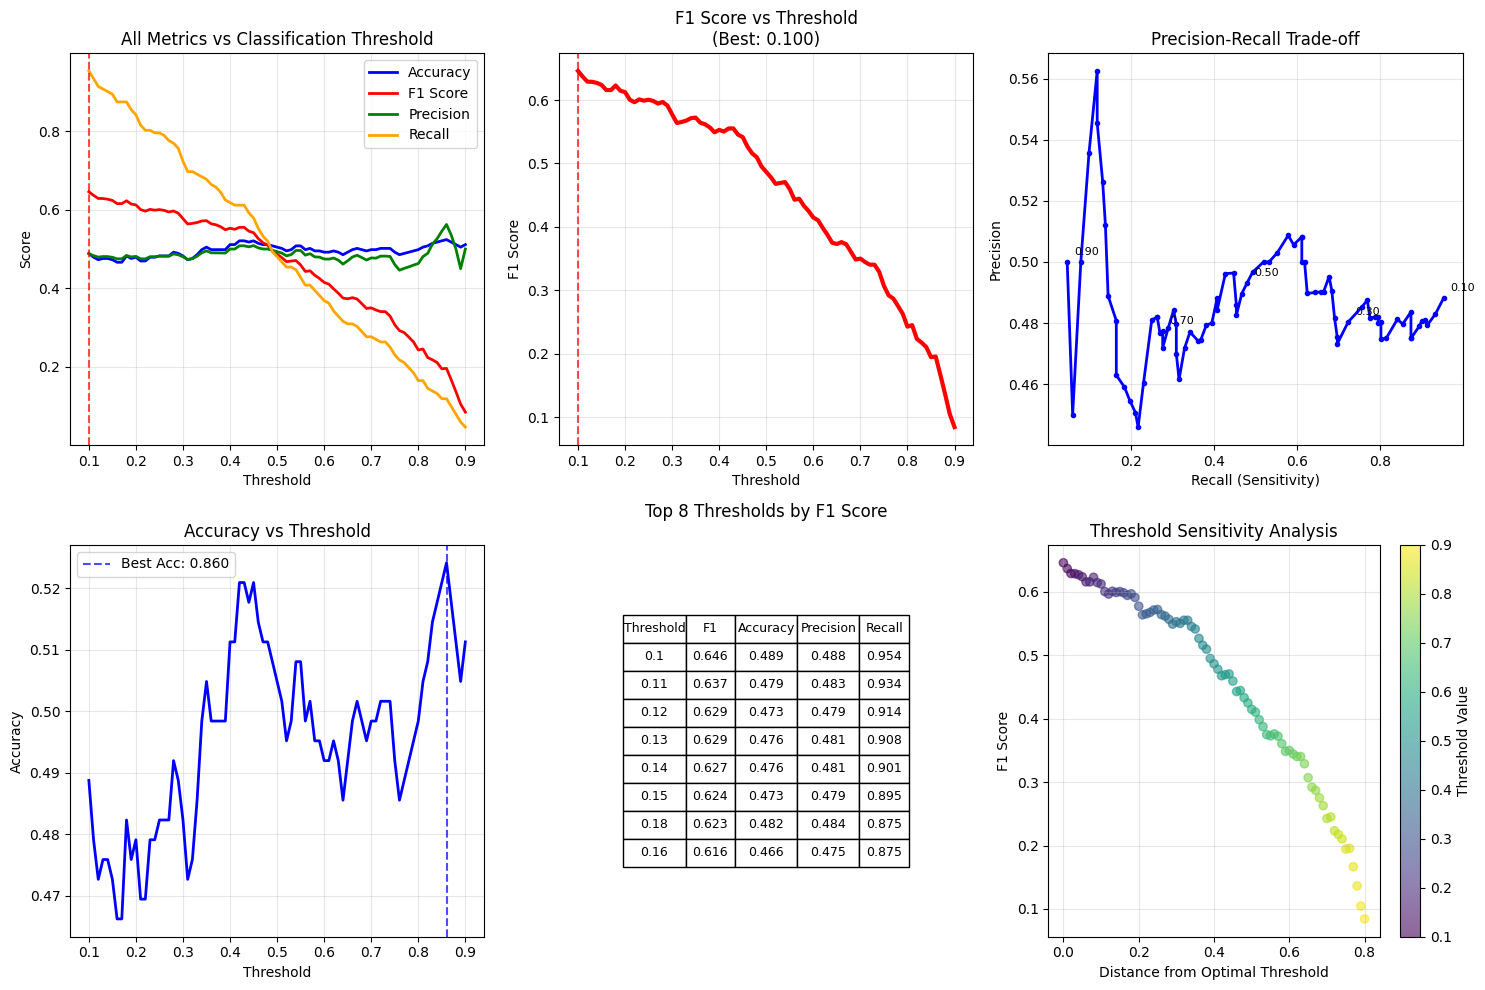


📊 THRESHOLD OPTIMIZATION RESULTS:
Optimal threshold: 0.860

Performance at optimal threshold:
  F1 Score:   0.6459
  Accuracy:   0.4887
  Precision:  0.4882
  Recall:     0.9539

Comparison with default threshold (0.5):
  Default F1:       0.4867
  Optimized F1:     0.6459
  Improvement:      0.1592

✅ Threshold optimization completed!


In [112]:
# Optimize threshold on test set
print("Starting threshold optimization...")


optimal_threshold, threshold_results = optimize_threshold(
    training_results['model'], 
    training_results['test_loader'], 
    training_results['device'],
    metric='accuracy'  # Can change to 'accuracy' or 'balanced'
)

# Plot results
print("\nGenerating threshold analysis plots...")
threshold_fig = plot_threshold_analysis(threshold_results)
plt.show()

# Show detailed summary
df_thresh = pd.DataFrame(threshold_results)
best_row = df_thresh.loc[df_thresh['f1'].idxmax()]

print(f"\n📊 THRESHOLD OPTIMIZATION RESULTS:")
print(f"{'='*50}")
print(f"Optimal threshold: {optimal_threshold:.3f}")
print(f"\nPerformance at optimal threshold:")
print(f"  F1 Score:   {best_row['f1']:.4f}")
print(f"  Accuracy:   {best_row['accuracy']:.4f}")
print(f"  Precision:  {best_row['precision']:.4f}")
print(f"  Recall:     {best_row['recall']:.4f}")

# Compare with default threshold (0.5)
default_row = df_thresh[df_thresh['threshold'] == 0.5].iloc[0]
print(f"\nComparison with default threshold (0.5):")
print(f"  Default F1:       {default_row['f1']:.4f}")
print(f"  Optimized F1:     {best_row['f1']:.4f}")
print(f"  Improvement:      {best_row['f1'] - default_row['f1']:.4f}")

print("\n✅ Threshold optimization completed!")

## FInal Results

In [113]:
def evaluate_with_threshold(model, data_loader, device, threshold=0.5):
    """Evaluate model with custom threshold"""
    model.eval()
    all_probs, all_true = [], []

    with torch.no_grad():
        for smri, fmri in data_loader:
            try:
                smri = smri.to(device)
                fmri = fmri.to(device)
                labels = smri.y.to(device)

                fused_logits, *_ = model(smri, fmri)

                if torch.isnan(fused_logits).any() or torch.isinf(fused_logits).any():
                    continue

                probs = F.softmax(fused_logits, dim=1)
                all_probs.extend(probs[:, 1].cpu().numpy())
                all_true.extend(labels.cpu().numpy())

            except Exception as e:
                continue

    all_probs = np.array(all_probs)
    all_probs = np.nan_to_num(all_probs, nan=0.5)

    if len(all_probs) == 0:
        print("❌ No predictions — returning empty metrics.")
        return {
            'auc': 0.0, 'accuracy': 0.0, 'f1': 0.0,
            'sensitivity': 0.0, 'specificity': 0.0
        }

    # Print prediction distribution
    preds = (all_probs >= threshold).astype(int)
    print("🔍 Prediction distribution:", np.bincount(preds))

    return safe_metrics_fixed(all_true, preds, all_probs)

# Final evaluation with optimal threshold
print("🎯 Final evaluation with optimal threshold...")
final_metrics = evaluate_with_threshold(
    training_results['model'],
    training_results['test_loader'],
    training_results['device'],
    optimal_threshold
)

# Compare with default threshold (0.5)
default_metrics = evaluate_with_threshold(
    training_results['model'],
    training_results['test_loader'],
    training_results['device'],
    0.5
)

print(f"\n🎉 FINAL EVALUATION RESULTS")
print(f"{'='*60}")
print(f"Optimal threshold: {optimal_threshold:.3f}")

print(f"\n📊 Performance Comparison:")
print(f"{'Metric':<12} {'Default (0.5)':<15} {'Optimized':<12} {'Improvement':<12}")
print(f"{'-'*55}")

metrics_to_compare = ['auc', 'accuracy', 'f1', 'sensitivity', 'specificity']
for metric in metrics_to_compare:
    default_val = default_metrics[metric]
    optimal_val = final_metrics[metric]
    improvement = optimal_val - default_val
    
    print(f"{metric.capitalize():<12} {default_val:<15.4f} {optimal_val:<12.4f} {improvement:<+12.4f}")

print(f"\n✅ Threshold optimization stage completed!")
print(f"📈 Best improvement: F1 score increased by {final_metrics['f1'] - default_metrics['f1']:+.4f}")

🎯 Final evaluation with optimal threshold...
[Gate] Sample 00 - sMRI: 0.797, fMRI: 0.203
[Gate] Sample 01 - sMRI: 0.803, fMRI: 0.197
[Gate] Sample 02 - sMRI: 0.789, fMRI: 0.211
[Gate] Sample 03 - sMRI: 0.782, fMRI: 0.218
[Gate] Sample 04 - sMRI: 0.768, fMRI: 0.232
[Gate] Sample 05 - sMRI: 0.788, fMRI: 0.212
[Gate] Sample 06 - sMRI: 0.780, fMRI: 0.220
[Gate] Sample 07 - sMRI: 0.784, fMRI: 0.216
[Gate] Sample 08 - sMRI: 0.788, fMRI: 0.212
[Gate] Sample 09 - sMRI: 0.786, fMRI: 0.214
[Gate] Sample 10 - sMRI: 0.776, fMRI: 0.224
[Gate] Sample 11 - sMRI: 0.801, fMRI: 0.199
[Gate] Sample 12 - sMRI: 0.790, fMRI: 0.210
[Gate] Sample 13 - sMRI: 0.776, fMRI: 0.224
[Gate] Sample 14 - sMRI: 0.810, fMRI: 0.190
[Gate] Sample 15 - sMRI: 0.776, fMRI: 0.224
[Gate] Sample 16 - sMRI: 0.781, fMRI: 0.219
[Gate] Sample 17 - sMRI: 0.777, fMRI: 0.223
[Gate] Sample 18 - sMRI: 0.785, fMRI: 0.215
[Gate] Sample 19 - sMRI: 0.805, fMRI: 0.195
[Gate] Sample 20 - sMRI: 0.780, fMRI: 0.220
[Gate] Sample 21 - sMRI: 0.797,

## Post Processing Ensembling

In [114]:
final_labels = []
for smri_batch, fmri_batch in training_results['test_loader']:
    final_labels.extend(smri_batch.y.numpy())
final_labels = np.array(final_labels)

# ==========================================================
# ENSEMBLE PREDICTIONS FOR ROBUSTNESS (Fusion Model)
# ==========================================================
print("\nENSEMBLE PREDICTIONS FOR ROBUSTNESS (Fusion Model)")
print("="*60)

# Switch to train mode to enable masking during inference
final_model = training_results['model']
device = training_results['device']
final_model.train()

ensemble_predictions = []

print("Generating ensemble predictions with masking...")
for run in range(10):  # 10 ensemble passes
    run_predictions = []

    with torch.no_grad():
        for smri_batch, fmri_batch in training_results['test_loader']:
            smri_batch = smri_batch.to(device)
            fmri_batch = fmri_batch.to(device)
            
            # Unpack logits from model output
            fused_logits, *_ = final_model(smri_batch, fmri_batch)
            
            # Softmax for probabilities
            probs = F.softmax(fused_logits, dim=1)
            run_predictions.extend(probs.cpu().numpy())
    
    ensemble_predictions.append(np.array(run_predictions))

# Average ensemble predictions
ensemble_predictions = np.array(ensemble_predictions)  # shape: (10, n_samples, 2)
mean_ensemble_probs = np.mean(ensemble_predictions, axis=0)
std_ensemble_probs = np.std(ensemble_predictions, axis=0)

print(f"✅ Ensemble of {len(ensemble_predictions)} prediction runs complete!")

# Apply threshold to ensemble predictions
ensemble_thresh_preds = (mean_ensemble_probs[:, 1] >= optimal_threshold).astype(int)

# Evaluate ensemble metrics
ensemble_metrics = {
    'auc': roc_auc_score(final_labels, mean_ensemble_probs[:, 1]),
    'accuracy': accuracy_score(final_labels, ensemble_thresh_preds),
    'f1': f1_score(final_labels, ensemble_thresh_preds),
    'sensitivity': recall_score(final_labels, ensemble_thresh_preds),
    'specificity': recall_score(final_labels, ensemble_thresh_preds, pos_label=0)
}

print(f"\n📊 Ensemble Results (threshold = {optimal_threshold:.3f}):")
print(f"  AUC:         {ensemble_metrics['auc']:.4f}")
print(f"  Accuracy:    {ensemble_metrics['accuracy']:.4f}")
print(f"  F1 Score:    {ensemble_metrics['f1']:.4f}")
print(f"  Sensitivity: {ensemble_metrics['sensitivity']:.4f}")
print(f"  Specificity: {ensemble_metrics['specificity']:.4f}")

# Prediction uncertainty analysis
avg_uncertainty = np.mean(std_ensemble_probs[:, 1])
print(f"  Average prediction uncertainty: {avg_uncertainty:.4f}")



ENSEMBLE PREDICTIONS FOR ROBUSTNESS (Fusion Model)
Generating ensemble predictions with masking...
✅ Ensemble of 10 prediction runs complete!

📊 Ensemble Results (threshold = 0.860):
  AUC:         0.4913
  Accuracy:    0.5080
  F1 Score:    0.1356
  Sensitivity: 0.0789
  Specificity: 0.9182
  Average prediction uncertainty: 0.0364


## Mask Feature Importance



sMRI Mask Importance: [0.0096463  0.01286174 0.02250804 0.02250804 0.03215434 0.02893891
 0.01607717 0.0192926  0.02893891 0.0096463  0.02250804 0.02250804
 0.03215434 0.0192926  0.02250804 0.01607717 0.0192926  0.02572347
 0.02572347 0.01607717 0.0192926  0.0192926  0.01607717 0.02250804
 0.01286174 0.01286174 0.04180064 0.01607717 0.01607717 0.02572347
 0.0192926  0.0096463  0.00643087 0.01286174 0.0096463  0.02250804
 0.02893891 0.01607717 0.01286174 0.02893891 0.03215434 0.0096463
 0.0192926  0.0192926  0.02250804 0.0096463  0.02572347 0.02893891
 0.01286174 0.02572347 0.0192926  0.01607717 0.02893891 0.01607717
 0.0192926  0.02250804 0.01607717 0.03536978 0.0192926  0.0192926
 0.01607717 0.0096463  0.02250804 0.02572347 0.02572347 0.0096463
 0.02893891 0.01607717 0.0096463  0.02893891 0.02572347 0.0192926
 0.01607717 0.01607717 0.02572347]
fMRI Mask Importance: [0.0192926  0.03858521 0.0192926  0.02572347 0.01286174 0.02250804
 0.0096463  0.01286174 0.01286174 0.01607717 0.0225080

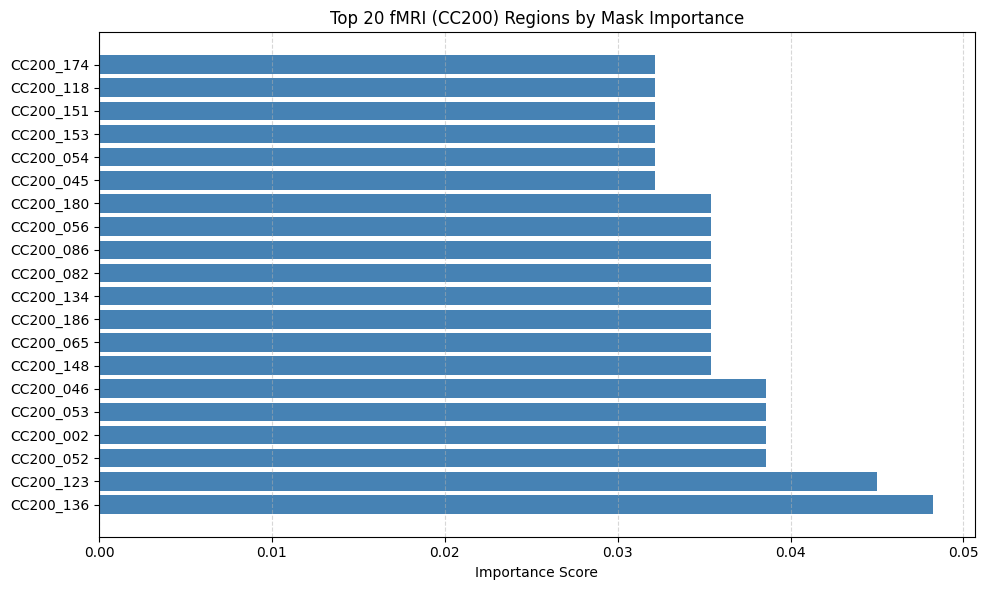

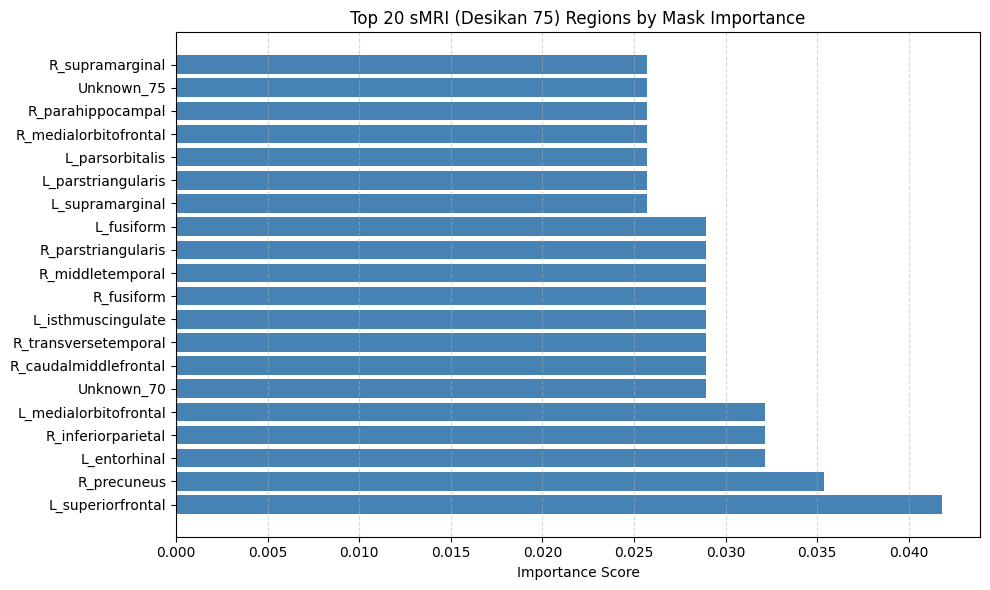

In [115]:
smri_mask_imp = training_results['smri_mask_importance']
fmri_mask_imp = training_results['fmri_mask_importance']

print("sMRI Mask Importance:", smri_mask_imp)
print("fMRI Mask Importance:", fmri_mask_imp)

# Create region name lists for CC200 (fMRI) and Desikan-Killiany (sMRI with 75 regions)

# CC200 regions are often unnamed and indexed (Region_001 to Region_200)
cc200_names = [f"CC200_{i+1:03d}" for i in range(200)]

# Desikan-Killiany with 75 ROIs — usually 34 per hemisphere + 7 extra (e.g., brainstem or ventricles)
desikan_base_names = [
    "bankssts", "caudalanteriorcingulate", "caudalmiddlefrontal", "cuneus", "entorhinal", "fusiform",
    "inferiorparietal", "inferiortemporal", "isthmuscingulate", "lateraloccipital", "lateralorbitofrontal",
    "lingual", "medialorbitofrontal", "middletemporal", "paracentral", "parahippocampal", "parsopercularis",
    "parsorbitalis", "parstriangularis", "pericalcarine", "postcentral", "posteriorcingulate", "precentral",
    "precuneus", "rostralanteriorcingulate", "rostralmiddlefrontal", "superiorfrontal", "superiorparietal",
    "superiortemporal", "supramarginal", "frontalpole", "temporalpole", "transversetemporal", "insula"
]
# Create L/R variants and add brainstem to get 75
desikan_75 = [f"L_{name}" for name in desikan_base_names] + \
             [f"R_{name}" for name in desikan_base_names] + ["Brainstem"]

import pickle

# Save both for later use
with open("cc200_region_names.pkl", "wb") as f:
    pickle.dump(cc200_names, f)

with open("desikan75_region_names.pkl", "wb") as f:
    pickle.dump(desikan_75, f)

cc200_names[:5], desikan_75[:5]  # show preview

# Load region names
with open("cc200_region_names.pkl", "rb") as f:
    cc200_regions = pickle.load(f)
with open("desikan75_region_names.pkl", "rb") as f:
    desikan_regions = pickle.load(f)

# Retrieve mask importances from training_results
fmri_importance = training_results.get("fmri_mask_importance")
smri_importance = training_results.get("smri_mask_importance")

print("fMRI importance:", type(fmri_importance), np.shape(fmri_importance))
print("sMRI importance:", type(smri_importance), np.shape(smri_importance))

print("Length of desikan_regions:", len(desikan_regions))
print("Length of smri_importance:", len(smri_importance))

while len(desikan_regions) < len(smri_importance):
    desikan_regions.append(f"Unknown_{len(desikan_regions)+1}")


# Helper function for plotting
def plot_mask_importance(values, region_names, title, top_k=20):
    if values is None:
        print(f"No values to plot for {title}")
        return

    # Convert to numpy and sort by importance
    values = np.array(values)
    sorted_idx = np.argsort(values)[::-1][:top_k]
    top_regions = [region_names[i] for i in sorted_idx]
    top_values = values[sorted_idx]

    plt.figure(figsize=(10, 6))
    bars = plt.barh(range(top_k), top_values[::-1], color='steelblue')
    plt.yticks(range(top_k), top_regions[::-1])
    plt.xlabel("Importance Score")
    plt.title(f"Top {top_k} {title} Regions by Mask Importance")
    plt.gca().invert_yaxis()
    plt.grid(True, axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Generate plots
plot_mask_importance(fmri_importance, cc200_regions, "fMRI (CC200)")
plot_mask_importance(smri_importance, desikan_regions, "sMRI (Desikan 75)")

[fetch_atlas_schaefer_2018] Dataset found in /Users/joemargolis/nilearn_data/schaefer_2018


/var/folders/49/_gwn31cj245fpwf4x7q7l7x40000gn/T/ipykernel_3391/3596035165.py:25: UserWarning: Could not determine cut coords: All voxels were masked by the thresholding. Returning the center of mass instead.
  plotting.plot_stat_map(importance_img, display_mode='ortho', threshold=0.1,
/var/folders/49/_gwn31cj245fpwf4x7q7l7x40000gn/T/ipykernel_3391/3596035165.py:25: UserWarning: empty mask
  plotting.plot_stat_map(importance_img, display_mode='ortho', threshold=0.1,


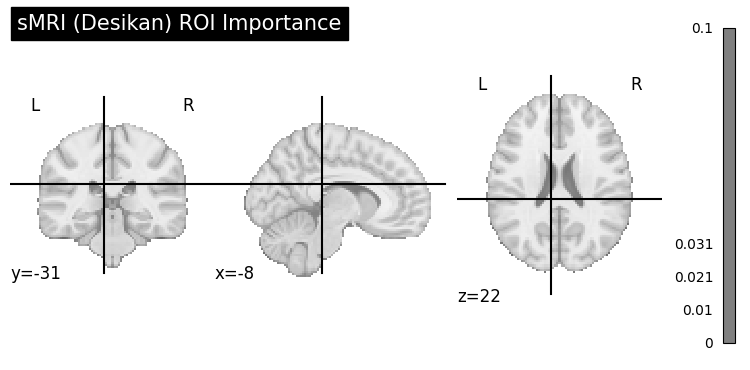

In [116]:
import nibabel as nib
from nilearn import plotting, datasets, image
import matplotlib.pyplot as plt
import pickle

# Load region names and importances
with open("desikan75_region_names.pkl", "rb") as f:
    desikan_regions = pickle.load(f)

smri_importance = training_results['smri_mask_importance']  # Replace with your actual values

# Load Schaefer 100-parcel atlas as a stand-in
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100, resolution_mm=1)
atlas_img = image.load_img(atlas['maps'])
atlas_data = atlas_img.get_fdata()

# Build ROI map
roi_map = np.zeros_like(atlas_data)
for i, imp in enumerate(smri_importance, start=1):
    roi_map[atlas_data == i] = imp

importance_img = nib.Nifti1Image(roi_map, affine=atlas_img.affine)

# Plot stat map
plotting.plot_stat_map(importance_img, display_mode='ortho', threshold=0.1,
                       title="sMRI (Desikan) ROI Importance", colorbar=True)
plt.show()

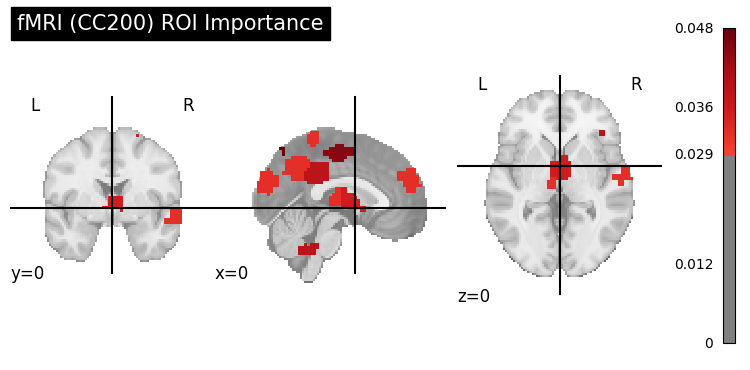

In [117]:
# Load CC200 atlas
atlas_path = "CC200.nii.gz"  # Update path
atlas_img = nib.load(atlas_path)
atlas_data = atlas_img.get_fdata()

# Load fMRI importance
fmri_importance = np.array(training_results['fmri_mask_importance'])  # shape: (200,)

# Create map
fmri_roi_map = np.zeros_like(atlas_data)
for i, imp in enumerate(fmri_importance, start=1):
    fmri_roi_map[atlas_data == i] = imp

# Create Nifti image
importance_img = nib.Nifti1Image(fmri_roi_map, affine=atlas_img.affine)

# Plot
plotting.plot_stat_map(
    importance_img,
    title="fMRI (CC200) ROI Importance",
    cmap='Reds',
    threshold=np.percentile(fmri_importance, 85),  # Top 15%
    cut_coords=(0, 0, 0),
    display_mode='ortho',
    colorbar=True
)
plt.show()